# A direct-then-inverse coupled artificial neural network for the acoustic inverse scattering problem

In this notes, we will explore the online step of the inverse problem across various test cases, demonstrating the performance of our model.

In [1]:
# -*- coding: utf-8 -*-
"""NN_pythorch.ipynb
by JDMV
"""

#import packages
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import time

# fixed the random seed
np.random.seed(73)


# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


We loaded two neural networks (NNs) in `Coupled_NNs`: DNN, the direct NN trained in the offline step, and INN, the inverse NN that will be trained in the online step.

Recall that the direct NN was trained with four different shapes: Circles, Ellipses, Kites, and Virus shapes. Therefore, if you need to reconstruct another shape, the direct NN must be retrained to learn the far-field pattern of that specific boundary form.

The offline step involves the trained neural network $\mathcal{D$}, which maps boundary points to their corresponding far-field pattern measurements. We also selected 64 evenly spaced incident wave directions for the training data. Consequently, for each shape, we created 64 'X' data samples, with each sample represented as a vector. The first component of each vector indicates the incident wave's angle direction, while the remaining 128 components represent the 64 boundary points, with both x and y coordinates included. As a result, the 'X' data has a shape of (64000, 129).

On the other hand, we used the Nystrom method to generate the associated far-field patterns for each 'X' data sample. These far-field pattern measurements are stored in the 'Y' vector, which has a shape of (64000, 128). In this case, the number 128 represents the 64 measurements of the far-field pattern, including both real and imaginary parts for each direction.

In the online step, we will use the inverse NN (INN). There are two representations: the Fourier series representation, where the loss function to find the coefficients is given by

\begin{equation}
J(W,b;t,u_\infty) = \frac{1}{2}\sum_{i=1}^M || u_\infty^i-\mathcal{D}(T(\mathcal{I}(t)),d^i)||^2+\lambda_1\sum_{j=1}^q j^2(\mathcal{I}j^2(t)+\mathcal{I}{j+q}^2(t))+\lambda_2 |\mathcal{I}_0(t)|.
\end{equation}

where the outputs of the NN $\mathcal{I}$ are the coefficients of the Fourier series.

The other representation is the cosine series, where the loss function to find the coefficients is as follows:

\begin{equation}
J(W,b;t,u_\infty) = \frac{1}{2}\sum_{i=1}^M || u_\infty^i-\mathcal{D}(C(\mathcal{I}(t)),d^i)||^2.
\end{equation}



In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('./Coupled_NNs')
sys.path.append('./Data_for_figures')

from CDINN import *


There are five different cases to test our model.

Then we load the test case.

In [8]:
#Load the data
torch.manual_seed(73)
np.random.seed(73)


#Load the far-field pattern with 64 measurements, split into real and imaginary parts.
# with this far-field patter we will to reconstruc the shape in the online step
i=3
testcase=np.load(f'./Data_for_figures/u_inf_Case{i}.npy')



#Load the real boundary
boundarytest=np.load(f'./Data_for_figures/boundarytestcase{i}.npy')




We can choose the number of incident wave directions with the variable npts. We can also add Gaussian noise to our test case.

In [9]:
# Number of incident wave directions. (Maximum 64)
npts=8

directions=np.linspace(0,2.0*np.pi*(npts-1.0)/npts,npts,endpoint=True)
ds=directions.shape
directions=directions.reshape(ds[0],1)

t=np.linspace(0,2.0*np.pi*(64-1.0)/64,64,endpoint=True)

params=np.array([t for  i in range(len(directions))])


# add noise to the far-field pattern data.
sigma_ruido=0.01*max(abs(testcase[0])) # 1% of noise

testcase_noise=testcase +np.random.normal(0,sigma_ruido,(64,128))

#We select the far field pattern for each direction of incidence

testcase_noise=testcase_noise[::int(64/npts)]



We can set the inverse NN with INN class. So we can test different number of neurons, layers, activation function and choice of form representation.

In [10]:
%%time
# Set our inverse NN
# The last layer contains the number of parameters to be recovered for the display form.

layers=[64,64,128,64,10] #11 [a_0,...,a_5,b_1,...,b5,h,k]
activations=[torch.nn.Tanh,torch.nn.Tanh,torch.nn.Tanh,torch.nn.Identity]

inverse_NN=INN(layers,activations)

#Online step. We can choose the form of representation (cosine or Fourier series)


inverse_NN.train(params,testcase_noise,directions,representation='Cosine_series',
                 lamb1=0,lamb2=0)



Iter 10, Loss: 1.34768e-02
Iter 20, Loss: 9.62577e-03
Iter 30, Loss: 9.34014e-03
Iter 40, Loss: 6.11144e-03
Iter 50, Loss: 2.11960e-03
Iter 60, Loss: 3.57096e-04
Iter 70, Loss: 1.14082e-04
Iter 80, Loss: 1.13665e-04
CPU times: user 736 ms, sys: 10.3 ms, total: 747 ms
Wall time: 750 ms


Finally, we are ready to plot the results:

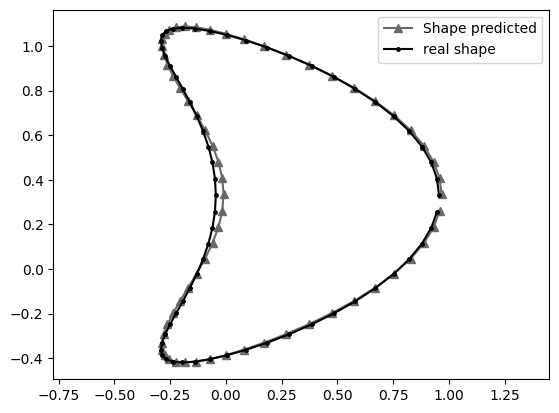

In [11]:
coeficients_predicted,boundary_predicted=inverse_NN.predict(params)

plt.plot(boundary_predicted[:,0],boundary_predicted[:,1],'^-',color='dimgray',
         label='Shape predicted')


plt.plot(boundarytest[1::2],boundarytest[2::2],'o-',color='black',
         label='real shape',markersize=2.5)

plt.axis('equal')
plt.legend()
plt.show()